# Mendapatkan Data

In [ ]:
!pip install youtube-comment-downloader

In [ ]:
from itertools import islice
from youtube_comment_downloader import *
import pandas as pd

def get_comments(url):
    downloader = YoutubeCommentDownloader()
    comments = downloader.get_comments_from_url(url, sort_by=SORT_BY_POPULAR)
    return comments

comments = get_comments('https://youtu.be/P4a_RRygi-c?si=gsAjESoz8gzdmUXp')

In [ ]:
comments = pd.DataFrame(comments)
comments = comments['text'].to_frame()
comments.head()

,text
0,"Apapun Gamenya, Follow Akunnya.\n- Honor of Ki..."
1,"Kalau ga banyak bug2 aneh, ping bagus,ngerank ..."
2,"Gpp moonton panik, toh yang diuntungkan malah ..."
3,"saya suka persaingan, ketika 2 game bersaing, ..."
4,"Menurut ku, untuk menggeser posisi mobile lege..."


In [ ]:
comments.shape

(1575, 1)

In [ ]:
comments.to_csv('comments.csv', index=False)

# Preprosesing

In [ ]:
!pip install Sastrawi

In [ ]:
!git clone https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection.git

In [ ]:
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd

nltk.download('punkt')
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
slang_word = pd.read_csv('/content/id-multi-label-hate-speech-and-abusive-language-detection/new_kamusalay.csv',
                         encoding='latin-1',
                         names=['slang', 'baku']
                         )
slang_dict = dict(zip(slang_word['slang'], slang_word['baku']))

In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text)
  tokens = nltk.word_tokenize(text)
  stemmed_tokens = [stemmer.stem(token) for token in tokens]
  filtered_tokens = [token for token in stemmed_tokens if token not in string.punctuation]
  text = ' '.join(stemmed_tokens)
  return text

def filter_slang(text, slang_dict):
    words = text.split()
    replaced_text = ' '.join([slang_dict.get(word, word) for word in words])
    return replaced_text

In [ ]:
data = pd.read_csv('/content/comments.csv')
data['clean_text'] = data['text'].apply(filter_slang, slang_dict=slang_dict)
data['clean_text'] = data['clean_text'].apply(preprocess_text)

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(1575, 2)

In [ ]:
data.to_csv('data_clean.csv', index=False)

In [ ]:
data.head()

,text,clean_text
0,"Apapun Gamenya, Follow Akunnya.\n- Honor of Ki...",apa gamenya follow akun honor of kings mobile ...
1,"Kalau ga banyak bug2 aneh, ping bagus,ngerank ...",kalau banyak bug aneh merah muda bagusngerank ...
2,"Gpp moonton panik, toh yang diuntungkan malah ...",gpp moonton panik yang untung malah player mlb...
3,"saya suka persaingan, ketika 2 game bersaing, ...",suka saing game saing bagai player untung jadi...
4,"Menurut ku, untuk menggeser posisi mobile lege...",ku geser posisi mobile legends top moba indone...


# TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(data['clean_text'])

In [ ]:
X_text.shape

(1575, 4028)

### Mencari n component optimal untuk PCA

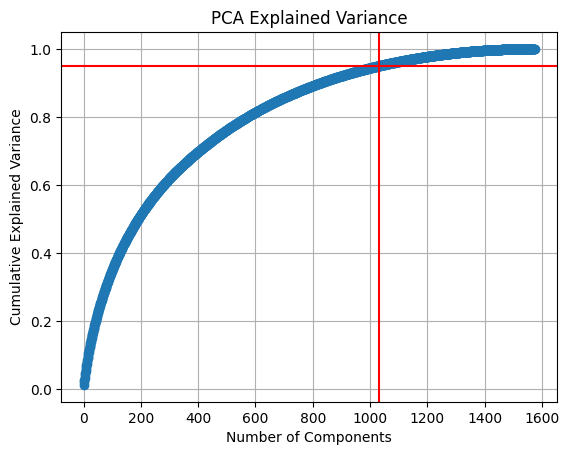

Jumlah komponen optimal: 1030


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_text.toarray())

# Hitung varians yang dijelaskan oleh setiap komponen
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot varians kumulatif
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='-')
plt.show()

# Menentukan jumlah komponen optimal
n_components_optimal = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Jumlah komponen optimal: {n_components_optimal}")


### PCA dengan componen optimal

In [ ]:
pca = PCA(n_components=n_components_optimal)
X_reduced = pca.fit_transform(X_text.toarray())

In [ ]:
X_reduced.shape

(1575, 1030)

In [ ]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

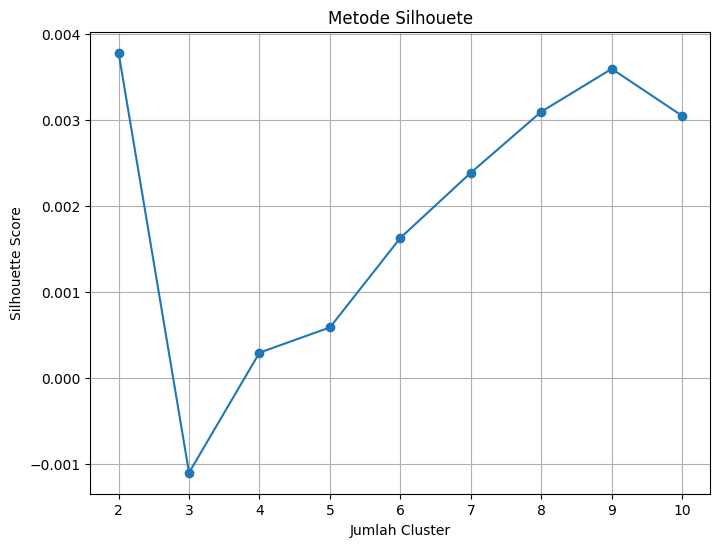

In [ ]:
from sklearn.metrics import silhouette_score

silhouettes = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    silhouettes.append(silhouette_score(X_reduced, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouettes, marker='o')
plt.title('Metode Silhouete')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9, random_state=42)
labels = kmeans.fit_predict(X_reduced)

data['cluster'] = labels
data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,text,clean_text,cluster
0,"Apapun Gamenya, Follow Akunnya.\n- Honor of Ki...",apa gamenya follow akun honor of kings mobile ...,7
1,"Kalau ga banyak bug2 aneh, ping bagus,ngerank ...",kalau tidak banyak bug aneh merah muda bagusng...,7
2,"Gpp moonton panik, toh yang diuntungkan malah ...",gpp moonton panik toh yang untung malah player...,2
3,"saya suka persaingan, ketika 2 game bersaing, ...",saya suka saing ketika game saing kita bagai p...,0
4,"Menurut ku, untuk menggeser posisi mobile lege...",turut ku untuk geser posisi mobile legends dar...,7
...,...,...,...
1570,@onzaioku4177 goblo goblo... Gw season kemar...,goblok goblo gw season kemarin ke mithyc wr bo...,2
1571,@onzaioku4177 bacotan lu kek legend yang gw ...,bacot kamu kayak legend yang gue ajak by one k...,2
1572,"@onzaioku4177 4 tahun, napa emangnya bahas l...",tahun kenapa memang bahas lama main lah lah si...,3
1573,@akunyoutube8575 nah inilah gue sebut di awa...,nah ini gue sebut di awal bocil tidak jelas,2


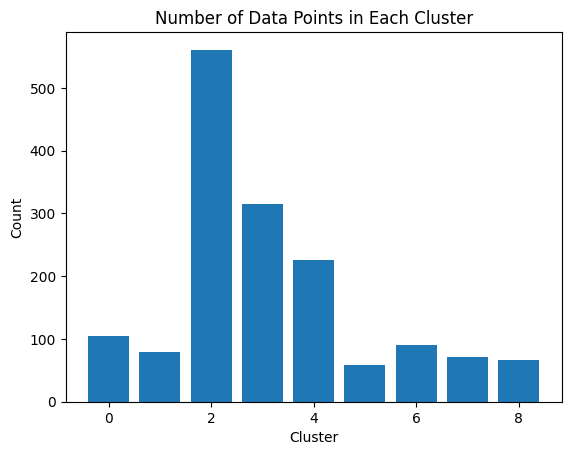

In [ ]:
import matplotlib.pyplot as plt

cluster_counts = data['cluster'].value_counts()

plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Data Points in Each Cluster')
plt.show()


# Output tiap cluster

## Cluster 0

In [ ]:
data[data['cluster'] == 0].head()

,text,clean_text,cluster
3,"saya suka persaingan, ketika 2 game bersaing, ...",saya suka saing ketika game saing kita bagai p...,0
13,Emang wajib ada persaingan sih khususnya di in...,emang wajib ada saing sih khusus di indo biar ...,0
21,kliatannya Tencent bakal monopoli pasar MOBA m...,lihat tencent bakal monopoli pasar moba mobile...,0
49,Masalah ketemu lawan balance tuh keknya susah ...,masalah ketemu lawan balance itu seperti susah...,0
62,"@Vierce666 oalah pantesan, gw ga maenin yang...",walah pantesan gue tidak main yang versi cina ...,0


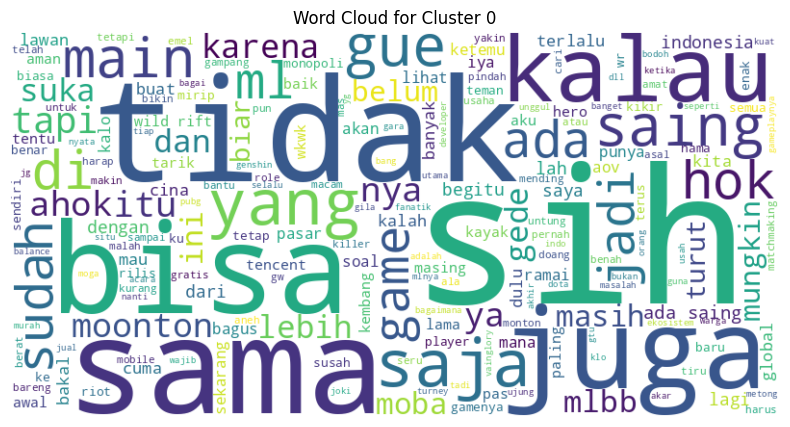

In [ ]:
from wordcloud import WordCloud
cluster_0_text = ' '.join(data[data['cluster'] == 0]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_0_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0')
plt.show()


## Cluster 1

In [ ]:
data[data['cluster'] == 1].head()

,text,clean_text,cluster
24,"susah bray, hok itu aov tapi background cina, ...",susah bray ahok itu aov tapi background cina p...,1
35,@user-ms4ve8il4h moba mobile yang enak itu w...,msveilh moba mobile yang enak itu wildrift sam...,1
38,@wildanathanarotama dia bukan aov 2.0 lebih ...,dia bukan aov lebih tepat bapak aov mau lihat ...,1
63,​ @Starlour aku anak aov sudah main mlbb TAPI ...,aku anak aov sudah main mlbb tapi bener hero m...,1
70,@tatalalu1925 tentu jorjoran server tencent ...,tentu jorjoran server tencent tidak perlu dira...,1


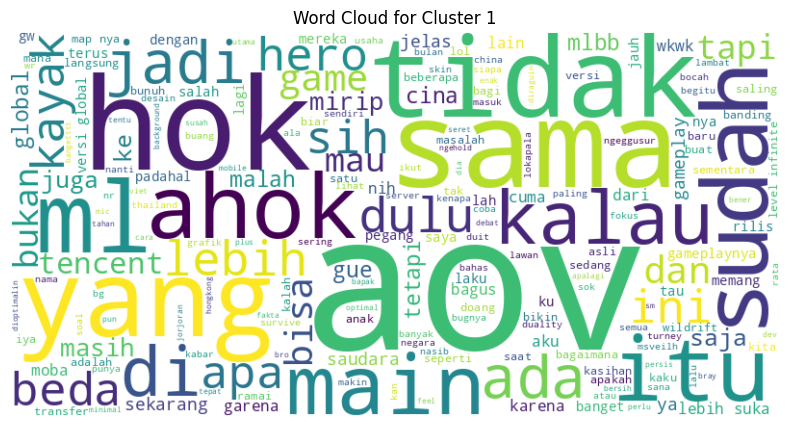

In [ ]:
from wordcloud import WordCloud
cluster_1_text = ' '.join(data[data['cluster'] == 1]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_1_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1')
plt.show()

## Cluster 2

In [ ]:
data[data['cluster'] == 2].head()

,text,clean_text,cluster
2,"Gpp moonton panik, toh yang diuntungkan malah ...",gpp moonton panik toh yang untung malah player...,2
23,Nah itu dia..match making yg tak seimbang memb...,nah itu diamatch making yang tak imbang buat p...,2
26,​​ @wildanathanarotama itu feel lu doang kali\...,itu feel kamu doang kali asa gameplay hok jauh...,2
33,@user-ms4ve8il4h ga nyambung yang bandingin ...,msveilh tidak sambung yang banding ahok sama m...,2
34,@user-ms4ve8il4h gameplay delay gitu dibilan...,msveilh gameplay delay begitu bilang smooth la...,2


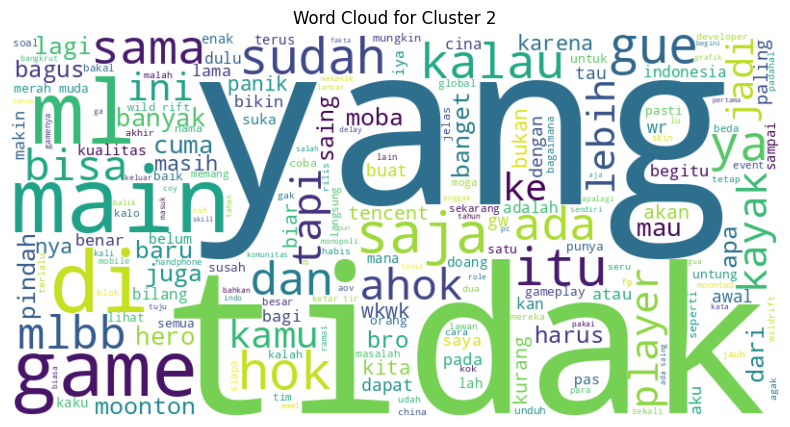

In [ ]:
from wordcloud import WordCloud
cluster_2_text = ' '.join(data[data['cluster'] == 2]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_2_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2')
plt.show()

## Cluster 3

In [ ]:
data[data['cluster'] == 3].head()

,text,clean_text,cluster
5,Buat apa pindah ke game hok yang gameplaynya g...,buat apa pindah ke game ahok yang gameplaynya ...,3
6,gw udh main ML hmpir 5 tahun dan udh ngeluarin...,gue sudah main ml hampir tahun dan sudah kelua...,3
10,Menurutku ML bisa mempertahankan playernya kar...,turut ml bisa tahan playernya karena alam soal...,3
11,"Gw udah nyoba HOK, dan yang gw rasakan cukup m...",gw sudah coba hok dan yang gue rasa cukup tari...,3
12,jujur fitur pilihan 2 role yg bikin gue tertar...,jujur fitur pilih role yang bikin gue tarik ba...,3


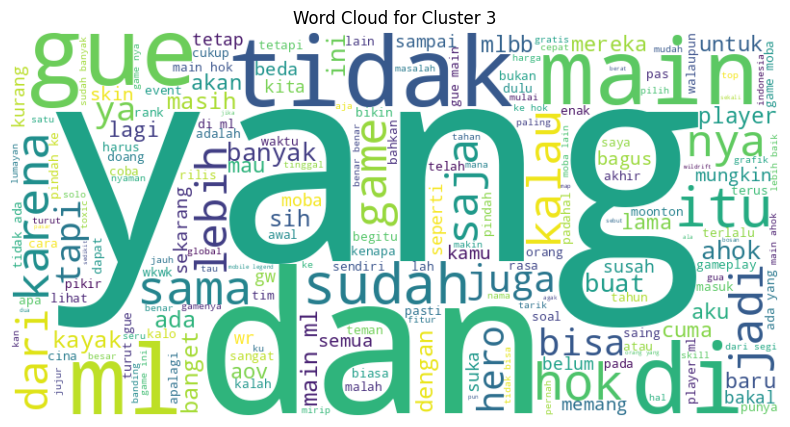

In [ ]:
from wordcloud import WordCloud
cluster_3_text = ' '.join(data[data['cluster'] == 3]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_3_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 3')
plt.show()

## Cluster 4

In [ ]:
data[data['cluster'] == 4].head()

,text,clean_text,cluster
7,"jujur pengen move ke HOK dari ML, udah 5 tahun...",jujur ingin pindah ke hok dari ml sudah tahun ...,4
8,"Kekurangan HOK, nama heronya terlalu China. Ka...",kurang hok nama hero terlalu china kalo ada sk...,4
9,Kesalahan terbesar tencnet tdk melirik asean s...,salah besar tencnet tidak lirik asean belum ml...,4
18,Wahai para kaum dark sistem montod mari buktik...,wahai para kaum dark sistem montod mari bukti ...,4
19,untuk fans HOK kalian jangan merasa udah di at...,untuk fan hok kalian jangan rasa sudah di atas...,4


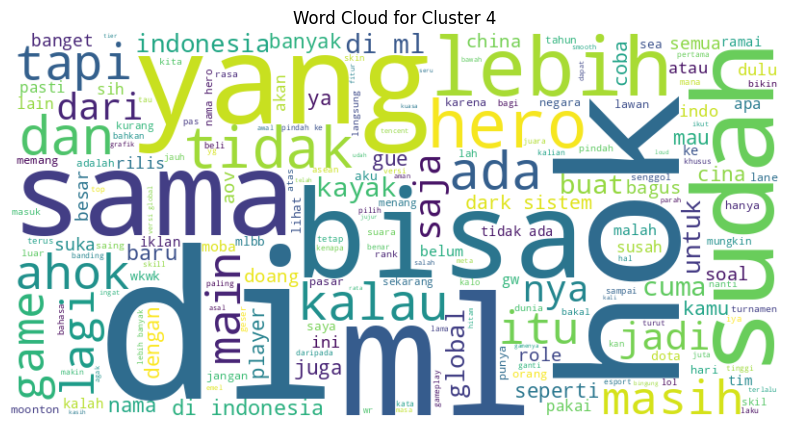

In [ ]:
from wordcloud import WordCloud
cluster_4_text = ' '.join(data[data['cluster'] == 4]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_4_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 4')
plt.show()

## Cluster 5

In [ ]:
data[data['cluster'] == 5].head()

,text,clean_text,cluster
51,Pingnya Bagus banget bang gua main guna data o...,pingnya bagus banget bang gue main guna data o...,5
66,​ @LiYe-yx1ls solo + indo yaudah mau ngarep ap...,yxls solo indonesia ya sudah mau harap apa men...,5
88,@wildanathanarotama setuju sama elu bang,tuju sama kamu bang,5
95,​ @Danesaurus nge rank ketemu lawan balance ma...,nge rank ketemu lawan balance adalah belum ten...,5
112,​ @wildanathanarotama device lu kali yg kentan...,device kamu kali yang kentang gue main smooth ...,5


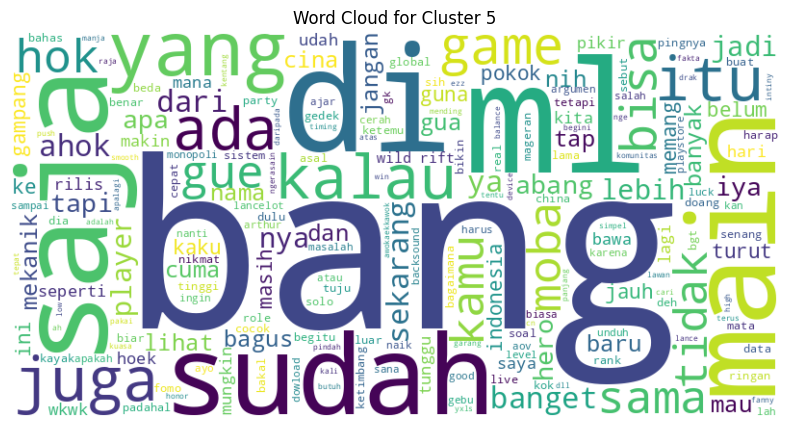

In [ ]:
from wordcloud import WordCloud
cluster_5_text = ' '.join(data[data['cluster'] == 5]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_5_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 5')
plt.show()

## Cluster 6

In [ ]:
data[data['cluster'] == 6].head()

,text,clean_text,cluster
20,"udh test smua ke 3 nya ,\n- wardrift map nya k...",sudah tes semua ke nya wardrift map nya ku tid...,6
58,​ @Danesaurus kalo emang bakal seimbang matchm...,kalau memang bakal imbang matchmaking nya otom...,6
59,​ @Danesaurus kalo emang bakal seimbang matchm...,kalau memang bakal imbang matchmaking nya otom...,6
65,Emang bener sih ping nya stabil bgt gk jumping...,emang benar sih merah muda nya stabil banget t...,6
101,​ @wildanathanarotama wkwkwk game smooth di bi...,wkwk game smooth di bilang kaku feel nya agak ...,6


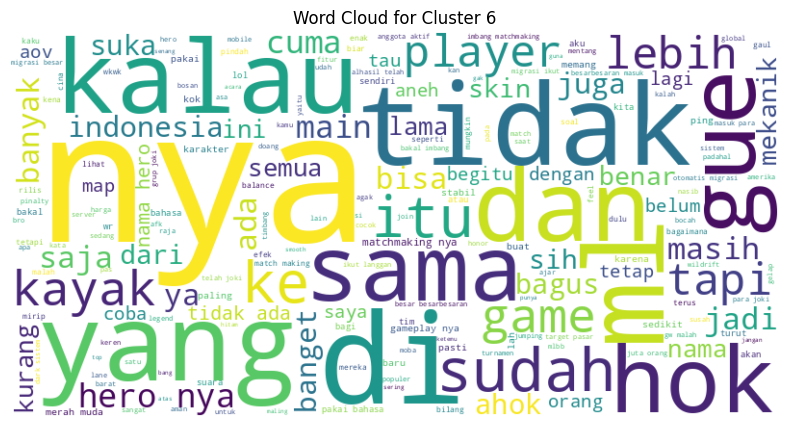

In [ ]:
from wordcloud import WordCloud
cluster_6_text = ' '.join(data[data['cluster'] == 6]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_6_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 6')
plt.show()

## Cluster 7

In [ ]:
data[data['cluster'] == 7].head()

,text,clean_text,cluster
0,"Apapun Gamenya, Follow Akunnya.\n- Honor of Ki...",apa gamenya follow akun honor of kings mobile ...,7
1,"Kalau ga banyak bug2 aneh, ping bagus,ngerank ...",kalau tidak banyak bug aneh merah muda bagusng...,7
4,"Menurut ku, untuk menggeser posisi mobile lege...",turut ku untuk geser posisi mobile legends dar...,7
15,yang terpenting ada liga dengan kasta tertingg...,yang penting ada liga dengan kasta tinggi di t...,7
16,Tencent harus melihat keluhan2 player mobile l...,tencent harus lihat keluh player mobile legend...,7


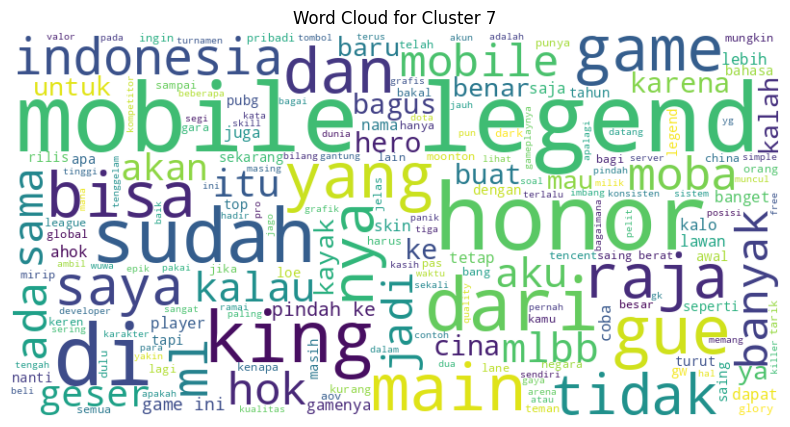

In [ ]:
from wordcloud import WordCloud
cluster_7_text = ' '.join(data[data['cluster'] == 7]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_7_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 7')
plt.show()

## Cluster 8

In [ ]:
data[data['cluster'] == 8].head()

,text,clean_text,cluster
17,Berkat HOK hari ini banyak Bansos di ML\nkaya ...,berkat hok hari ini banyak bansos di ml kayak ...,8
160,Wkwkwkwk banjir skin gratis 😂😂😂,wkwkwkwk banjir skin gratis,8
161,Gw nunggu hibah skin 🤓,gw tunggu hibah skin,8
162,Sama gw player AOV pun hujan skin gratis 😅😅😅\n...,sama gue player aov pun hujan skin gratis seme...,8
166,​ @user-vf9pu3rd6i Ml di-update map baru Hero ...,vfpurdi ml diupdate map baru hero nya bagus sa...,8


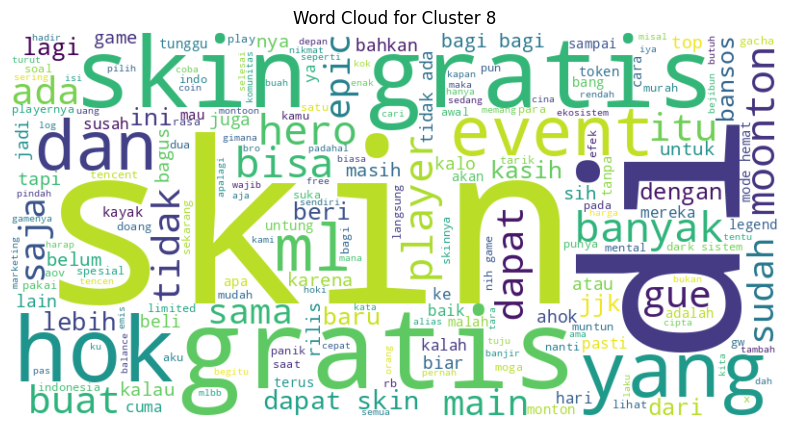

In [ ]:
from wordcloud import WordCloud
cluster_8_text = ' '.join(data[data['cluster'] == 8]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_8_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 8')
plt.show()